In [2]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
from scipy.stats import linregress

c:\users\ryan\appdata\local\programs\python\python38\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
PORTFOLIO_TICKERS = [ "SPY", "QQQ" ]
PORTFOLIO_WEIGHTS = [ .5, .5 ]

## Stock Data

In [4]:
START = "1970-01-01"
END = "2020-01-01"
PORTFOLIO = pd.DataFrame()

for ticker in PORTFOLIO_TICKERS:
    PORTFOLIO[ticker] = pdr.get_data_yahoo(ticker, START, END, interval="m").Close # change interval here when changing INTERVAL
    
PORTFOLIO = PORTFOLIO.dropna()

# SET PARAMS

In [21]:
NUM_YEARS = 20
INITIAL = 1000
CONTRIB = 100
INTERVAL = "month"

### Get params

In [22]:
divisors = {
    "day": 253,
    "month": 12
}
divisor = divisors[INTERVAL]


daily_change = np.array(PORTFOLIO)[1:,:] - np.array(PORTFOLIO)[:-1,:]
pct_change = np.divide( daily_change, np.array(PORTFOLIO)[:-1, :] ) + 1

pct_change_df = pd.DataFrame( dict( (PORTFOLIO_TICKERS[i], pct_change[:,i]) for i in range(len(PORTFOLIO_TICKERS)) ) )
pct_change_df.index = PORTFOLIO.index[:-1]
pct_change_df = pct_change_df.iloc[:NUM_YEARS * divisor, :]
time_len = pct_change_df.shape[0]

In [23]:
def calcRisk(init, contrib, time):
    return [ init + contrib * i for i in range(time) ]

def calcReturns(init, contrib, pct_changes):
    returns = []
    for i in range(len(pct_changes)):
        returns.append( ( returns[i-1] + contrib ) * pct_changes[i] if i > 0 else init * pct_changes[0] )
    return returns

# One Time Investment

In [24]:
# get risk over time
one_time_risk = calcRisk(INITIAL, 0, time_len)

# get returns over time
one_time_returns = pd.DataFrame( dict( ( PORTFOLIO_TICKERS[i], calcReturns(INITIAL * PORTFOLIO_WEIGHTS[i], 0, pct_change_df[PORTFOLIO_TICKERS[i]]) ) for i in range(len(PORTFOLIO_TICKERS)) ) )
one_time_returns.index = pct_change_df.index

# sum of returns
one_time_total_returns = one_time_returns.sum(axis=1)

# net gains
net_gains = one_time_total_returns[-1]-one_time_risk[-1]

print("Total returns from one initial investment of {} after {} years: ${}".format(INITIAL, one_time_returns.shape[0]/divisor, one_time_total_returns[-1]))
print("Total risk: ${}".format(one_time_risk[-1]))
print("Net gains: ${} -> {}".format(net_gains, net_gains/one_time_risk[-1]+1))

Total returns from one initial investment of 1000 after 20.0 years: $2812.281000224415
Total risk: $1000
Net gains: $1812.281000224415 -> 2.8122810002244147


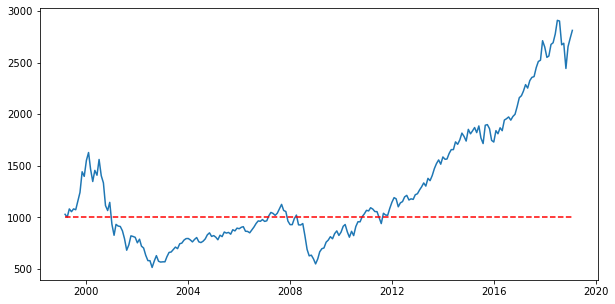

In [25]:
plt.figure(figsize=(10,5))
plt.plot(one_time_total_returns)
plt.plot(one_time_total_returns.index, one_time_risk, "r--")
plt.show()

# CONTINUOUS INVESTMENT

In [26]:
# get risk over time
continuous_risk = calcRisk(INITIAL, CONTRIB, time_len)

# get returns over time
continuous_returns = pd.DataFrame( dict( ( PORTFOLIO_TICKERS[i], calcReturns(INITIAL*PORTFOLIO_WEIGHTS[i], CONTRIB*PORTFOLIO_WEIGHTS[i], pct_change_df[PORTFOLIO_TICKERS[i]]) )
                                        for i in range(len(PORTFOLIO_TICKERS)) ) )
continuous_returns.index = pct_change_df.index

# sum of returns
continuous_total_returns = continuous_returns.sum(axis=1)

# net gains
net_gains = continuous_total_returns[-1]-continuous_risk[-1]

# divisor

print("Total returns from one initial investment of ${} with ${}/{} contribution after {} years: ${}".format(INITIAL, CONTRIB, INTERVAL, continuous_returns.shape[0]/divisor, continuous_total_returns[-1]))
print("Total risk: ${}".format(continuous_risk[-1]))
print("Net gains: ${} -> {}".format(net_gains, net_gains/continuous_risk[-1]+1))

Total returns from one initial investment of $1000 with $100/month contribution after 20.0 years: $68401.38984002735
Total risk: $24900
Net gains: $43501.38984002735 -> 2.7470437686757974


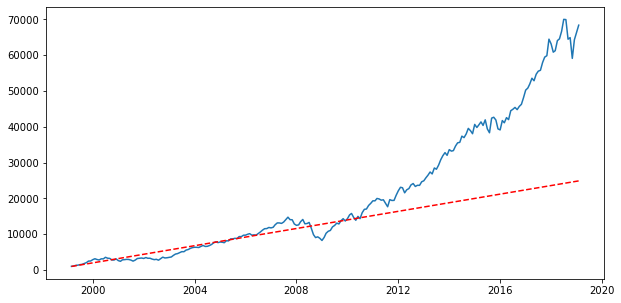

In [27]:
plt.figure(figsize=(10,5))
plt.plot(continuous_total_returns)
plt.plot(continuous_total_returns.index, continuous_risk, "r--")
plt.show()

# COMPARISON

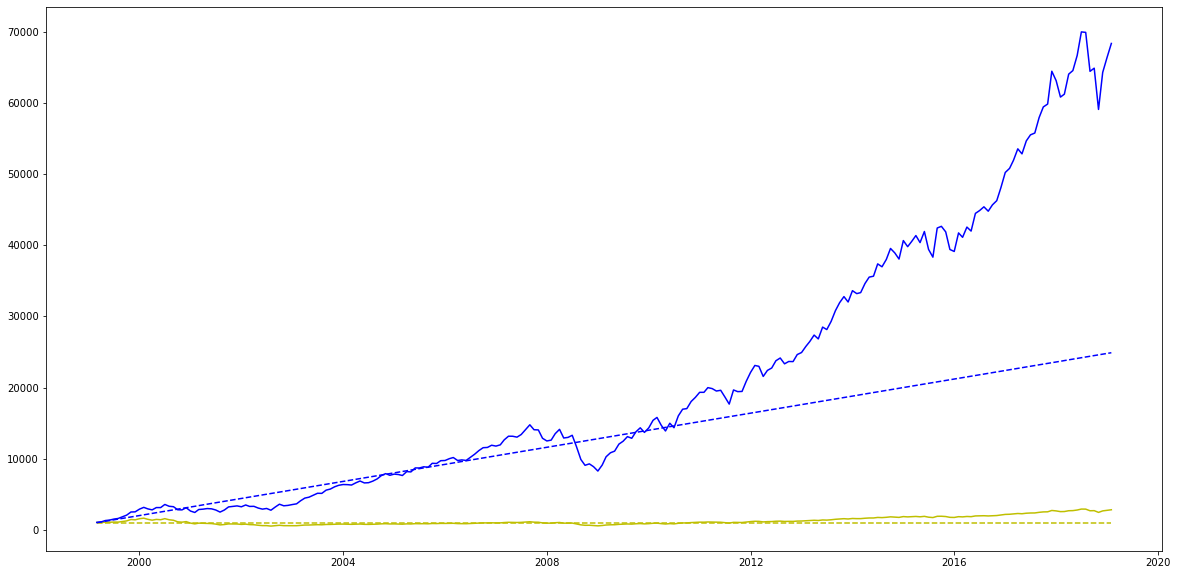

In [28]:
xticks = one_time_total_returns.index
plt.figure(figsize=(20,10)) 
plt.plot(xticks, one_time_total_returns, "y-")
plt.plot(xticks, one_time_risk, "y--")
plt.plot(xticks, continuous_total_returns, "b-")
plt.plot(xticks, continuous_risk, "b--")
plt.show()